# Imports

In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import torch.nn as nn
import torch.optim as optim
import json
import random
import copy
import matplotlib.pyplot as plt

# Dataset Generation

Evironment Variables:

In [ ]:
HAL_PATH = r"qa-hal.jsonl"
RIGHT_PATH = r"qa-right.jsonl"
WINDOW_SIZE = 5
K = 10
IS_HAL_LABEL = 1
IS_REAL_LABEL = 0

Dataset Wrapper:

In [ ]:
class LogitDataset:
    def __init__(self, sequences, labels):
        """
        sequences: numpy array of shape (num_samples, window_size, top_k)
        labels: numpy array of shape (num_samples,)
        """
        self.sequences = sequences
        self.labels = labels

    def get_numpy(self, flatten=False):
        if flatten:
            X = self.sequences.reshape(self.sequences.shape[0], -1)  # Flatten last two dims
        else:
            X = self.sequences
        y = self.labels
        return X, y

    def get_torch(self, flatten=False):
        X, y = self.get_numpy(flatten=flatten)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        return X_tensor, y_tensor

Creating Dataset Utils:

In [ ]:
def process_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                item = json.loads(line)
                yield item


def creating_records(start_hal, item, top_k_logits=None):
    record_list = []
    record_dict = []
    for chosed_token, tokens_probs in item["probabilities_for_tokens"].items():
        index = int(chosed_token.split(" - ")[0])
        if start_hal - WINDOW_SIZE <= index <= start_hal + WINDOW_SIZE:
            sorted_probs = sorted(tokens_probs.values(), reverse=True)
            if top_k_logits is not None:
                selected_probs = sorted_probs[:top_k_logits]
            else:
                selected_probs = sorted_probs
            record_list.append(selected_probs)
            record_dict.append(tokens_probs)

    return record_list, record_dict

In [ ]:
random.seed(100) # For determinism of dataset

dataset_list = []
dataset_dict = []

def pad_sequence(seq, target_len, pad_value=0.0):
    """Pads the sequence with pad_value (or edge values) until it reaches target_len."""
    if len(seq) >= target_len:
        return seq
    # Pad with copies of the last element
    padding = [seq[-1]] * (target_len - len(seq))
    return seq + padding

for item in process_jsonl(HAL_PATH):
    start_hal = item["start_hal"]
    record_hal_list, record_hal_dict = creating_records(start_hal, item, K)
    record_hal_list = pad_sequence(record_hal_list, 2*WINDOW_SIZE+1)
    dataset_list.append((record_hal_list, IS_HAL_LABEL))
    dataset_dict.append((record_hal_dict, IS_HAL_LABEL))

for item in process_jsonl(RIGHT_PATH):
    num_tokens = len(item["probabilities_for_tokens"])
    middle_index = num_tokens // 2
    first_start_hal = random.randint(0, middle_index)
    second_start_hal = random.randint(middle_index, num_tokens)
    record_right1_list, record_right1_dict = creating_records(first_start_hal, item, K)
    record_right1_list = pad_sequence(record_right1_list, 2*WINDOW_SIZE+1)
    dataset_list.append((record_right1_list, IS_REAL_LABEL))
    dataset_dict.append((record_right1_dict, IS_REAL_LABEL))
    record_right2_list, record_right2_dict = creating_records(second_start_hal, item, K)
    record_right2_list = pad_sequence(record_right2_list, 2*WINDOW_SIZE+1)
    dataset_list.append((record_right2_list, IS_REAL_LABEL))
    dataset_dict.append((record_right2_dict, IS_REAL_LABEL))


logit_sequences = np.array([logit_sequence for logit_sequence, label in dataset_list
                            if len(logit_sequence)==2*WINDOW_SIZE+1])
labels = np.array([label for logit_sequence, label in dataset_list
                   if len(logit_sequence)==2*WINDOW_SIZE+1])

Creating the dataset:

In [ ]:
dataset = LogitDataset(logit_sequences, labels)

# Flattening dataset for tabular models
X_np, y_np = dataset.get_numpy(flatten=True)
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

X_torch, y_torch = dataset.get_torch(flatten=True)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_torch, y_torch, test_size=0.2, random_state=42)

# Not flattening for sequence models
X_np_seq, y_np_seq = dataset.get_numpy(flatten=False)  # not flattened (11,10)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_np_seq, y_np_seq, test_size=0.2, random_state=42)

X_torch_seq, y_torch_seq = dataset.get_torch(flatten=False)
X_train_t_seq, X_test_t_seq, y_train_t_seq, y_test_t_seq = train_test_split(X_torch_seq, y_torch_seq, test_size=0.2, random_state=42)

# Classifiers

## **Decision Tree**

In [ ]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train_np, y_train_np)
tree_preds = tree.predict(X_test_np)

Decision Tree Classification Report:

In [ ]:
print(classification_report(y_test_np, tree_preds))

              precision    recall  f1-score   support

           0       0.92      0.50      0.65        22
           1       0.58      0.94      0.71        16

    accuracy                           0.68        38
   macro avg       0.75      0.72      0.68        38
weighted avg       0.77      0.68      0.68        38



Decision Tree Confusion Matrix:

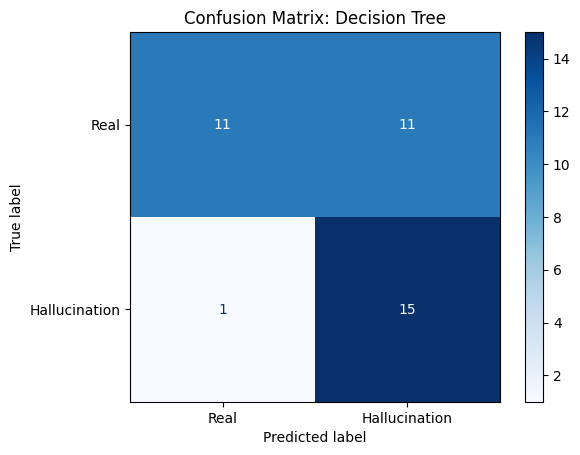

In [ ]:
cm = confusion_matrix(y_test_np, tree_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Hallucination"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Decision Tree')
plt.show()

## **Logistic Regression**

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_np, y_train_np)
lr_preds = lr.predict(X_test_np)

Logistic Regression Classification Report:

In [ ]:
print(classification_report(y_test_np, lr_preds))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74        22
           1       0.65      0.69      0.67        16

    accuracy                           0.71        38
   macro avg       0.70      0.71      0.71        38
weighted avg       0.71      0.71      0.71        38



Logistic Regression Confusion Matrix:

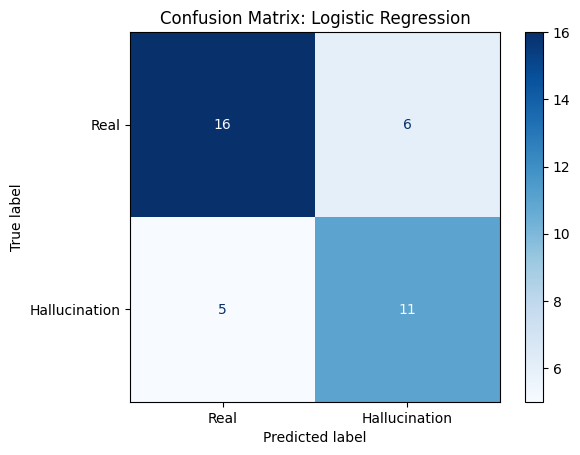

In [ ]:
cm = confusion_matrix(y_test_np, lr_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Hallucination"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

## **Support Vector Machine (SVM)**

In [ ]:
svm = SVC(kernel='rbf', C=1, gamma='scale', max_iter=1000)
svm.fit(X_train_np, y_train_np)
svm_preds = svm.predict(X_test_np)

SVM Classification Report:

In [ ]:
print(classification_report(y_test_np, svm_preds))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           1       0.72      0.81      0.76        16

    accuracy                           0.79        38
   macro avg       0.79      0.79      0.79        38
weighted avg       0.80      0.79      0.79        38



SVM Confusion Matrix:

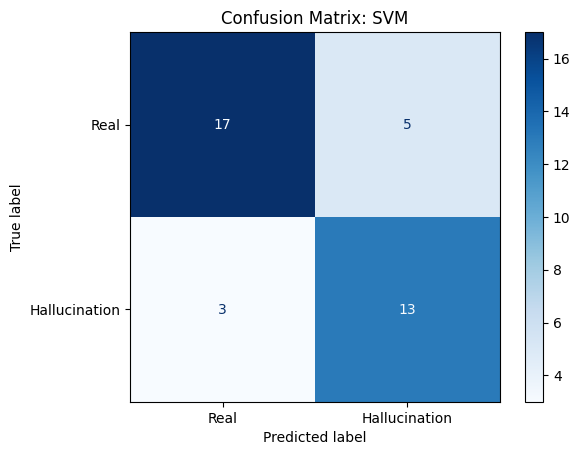

In [ ]:
cm = confusion_matrix(y_test_np, svm_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Hallucination"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: SVM')
plt.show()

## **Feed-Forward Neural Network**

First we will attempt a very small and basic FFNN structure to get a baseline and avoid overfitting, then, with the goal of scaling the system in mind, we will attempt a bit of a larger structure and see whether we get any improvements.

Tiny FFNN - only one hidden layer (32 neurons):

In [ ]:
class TinyFFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.net(x)

FFNN - 2 hidden layers (128 + 64 hidden neurons):

In [ ]:
class FFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

Toggle TinyFFNN/FFNN:

In [ ]:
ffnn_model_type = "FFNN"

if ffnn_model_type == "TinyFFNN":
    ffnn_model = TinyFFNN(input_dim=X_train_t.shape[1])
elif ffnn_model_type == "FFNN":
    ffnn_model = FFNN(input_dim=X_train_t.shape[1])
else:
    raise ValueError(f"Unknown model type: {ffnn_model_type}")

ffnn_model_batches = copy.deepcopy(ffnn_model)

Training the Feed-Forward Neural Network (full-batch training). (Toggle TinyFFNN/FFNN by need)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(ffnn_model.parameters(), lr=1e-3)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Number of training epochs
num_epochs = 320

for epoch in range(num_epochs):
    # Training
    ffnn_model.train()
    optimizer.zero_grad()
    output_train = ffnn_model(X_train_t)
    loss_train = loss_fn(output_train, y_train_t)
    loss_train.backward()
    optimizer.step()

    # Save train loss and accuracy
    train_losses.append(loss_train.item())
    train_preds = torch.argmax(output_train, dim=1)
    train_acc = (train_preds == y_train_t).float().mean().item()
    train_accuracies.append(train_acc)

    # Evaluation on test set
    ffnn_model.eval()
    with torch.no_grad():
        output_test = ffnn_model(X_test_t)
        loss_test = loss_fn(output_test, y_test_t)
        test_losses.append(loss_test.item())
        test_preds = torch.argmax(output_test, dim=1)
        test_acc = (test_preds == y_test_t).float().mean().item()
        test_accuracies.append(test_acc)


# === Final Predictions for report ===
ffnn_full_batch_preds = test_preds.numpy()

Plotting results of FFNN with full-batch training:

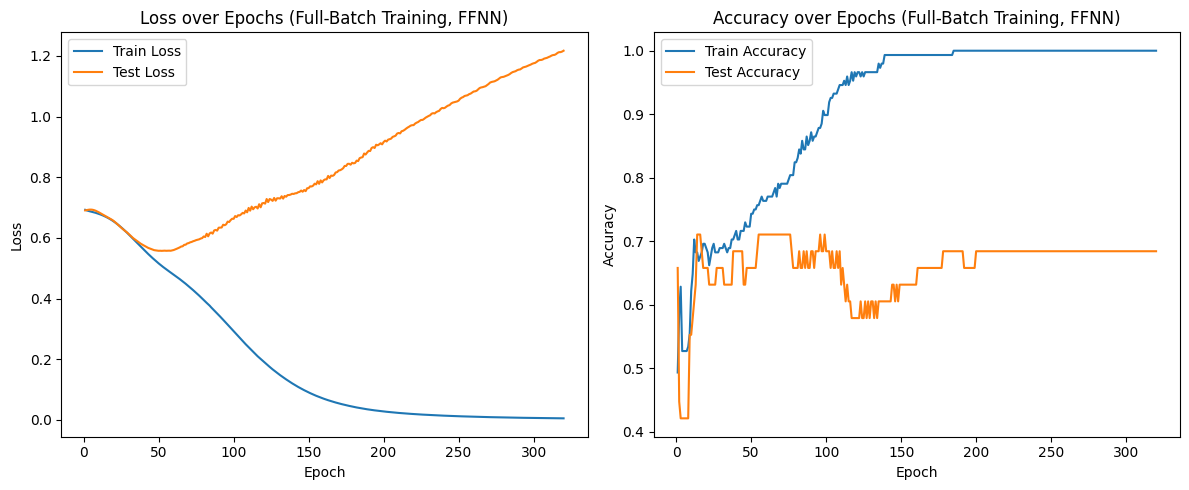

In [ ]:
epochs = range(1, num_epochs + 1)

# Plot losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss over Epochs (Full-Batch Training, {ffnn_model_type})')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over Epochs (Full-Batch Training, {ffnn_model_type})')
plt.legend()

plt.tight_layout()
plt.show()

FFNN (Full-Batch Training) Confusion Matrix:

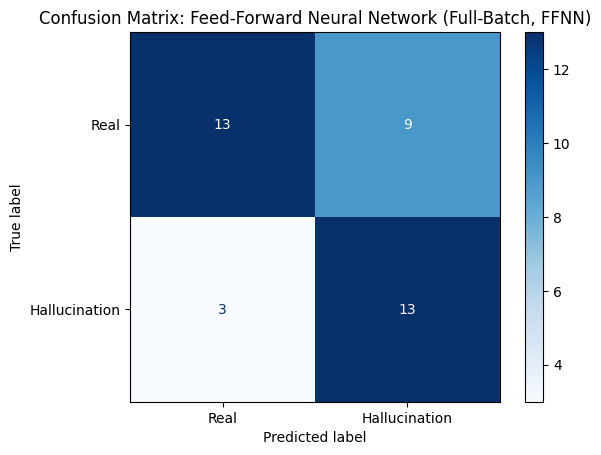

In [ ]:
cm = confusion_matrix(y_test_t, ffnn_full_batch_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Hallucination"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix: Feed-Forward Neural Network (Full-Batch, {ffnn_model_type})')
plt.show()

Training the Feed-Forward Neural Network (with mini-batches).

In [ ]:
# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

ffnn_model_batches = FFNN(input_dim=X_train_t.shape[1])
loss_fn = nn.CrossEntropyLoss()
optimizer_batches = optim.Adam(ffnn_model_batches.parameters(), lr=1e-3)

train_losses_batches = []
test_losses_batches = []
train_accuracies_batches = []
test_accuracies_batches = []

# Number of training epochs
num_epochs_batches = num_epochs

for epoch in range(num_epochs_batches):
    ffnn_model_batches.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for batch_X, batch_y in train_loader:
        optimizer_batches.zero_grad()
        output = ffnn_model_batches(batch_X)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer_batches.step()
        total_loss += loss.item()

        preds = torch.argmax(output, dim=1)
        correct_train += (preds == batch_y).sum().item()
        total_train += batch_y.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = correct_train / total_train

    train_losses_batches.append(avg_loss)
    train_accuracies_batches.append(train_acc)

    # Evaluate on test set
    ffnn_model_batches.eval()
    with torch.no_grad():
        output_test = ffnn_model_batches(X_test_t)
        loss_test = loss_fn(output_test, y_test_t)
        test_losses_batches.append(loss_test.item())
        preds_test = torch.argmax(output_test, dim=1)
        test_acc = (preds_test == y_test_t).float().mean().item()
        test_accuracies_batches.append(test_acc)

# === Final Predictions for report ===
ffnn_mini_batch_preds = preds_test.numpy()

Plotting results of FFNN with mini-batch training:

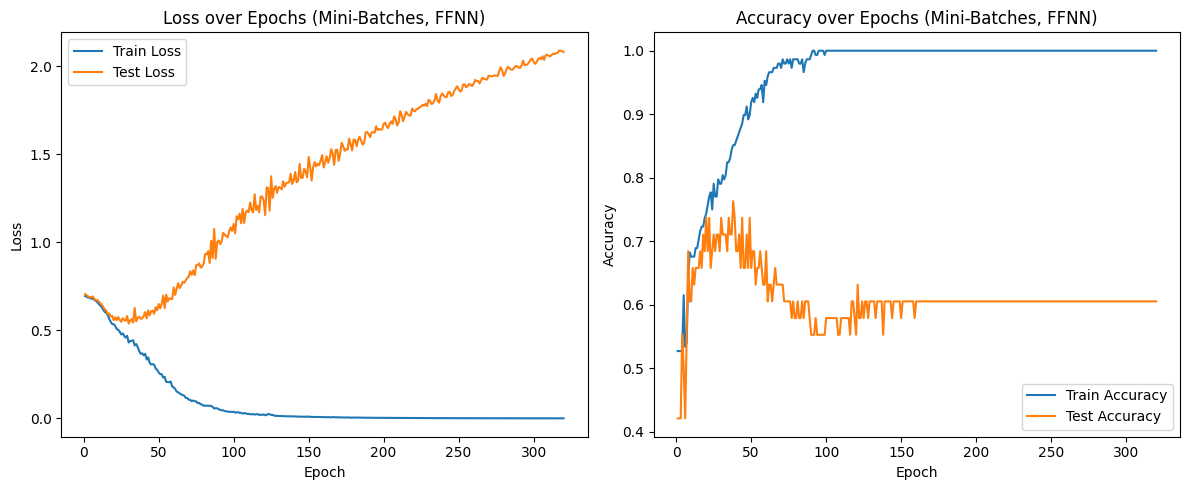

In [ ]:
epochs_batches = range(1, num_epochs_batches + 1)

# Plot losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_batches, train_losses_batches, label='Train Loss')
plt.plot(epochs_batches, test_losses_batches, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss over Epochs (Mini-Batches, {ffnn_model_type})')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_batches, train_accuracies_batches, label='Train Accuracy')
plt.plot(epochs_batches, test_accuracies_batches, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over Epochs (Mini-Batches, {ffnn_model_type})')
plt.legend()

plt.tight_layout()
plt.show()

FFNN (Mini-Batches Training) Confusion Matrix:

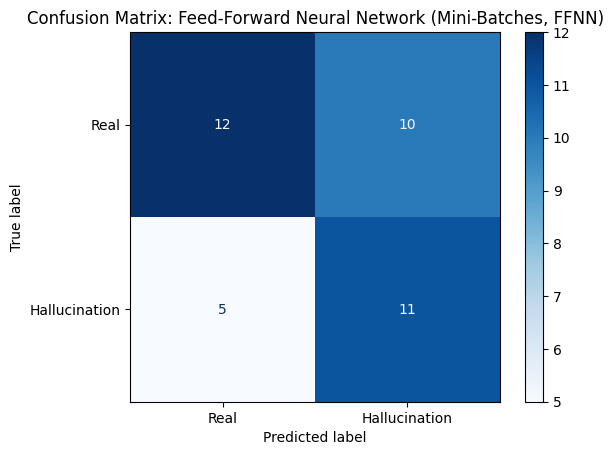

In [ ]:
cm = confusion_matrix(y_test_t, ffnn_mini_batch_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Hallucination"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix: Feed-Forward Neural Network (Mini-Batches, {ffnn_model_type})')
plt.show()

FFNN Classification Report

In [ ]:
print(f"Feed-Forward Neural Network (full-batch, {ffnn_model_type}):\n\n")
print(classification_report(y_test_t.numpy(), ffnn_full_batch_preds))

print(f"\n\nFeed-Forward Neutral Network (mini-batches, {ffnn_model_type}):\n\n")
print(classification_report(y_test_t.numpy(), ffnn_mini_batch_preds))

Feed-Forward Neural Network (full-batch, FFNN):


              precision    recall  f1-score   support

           0       0.81      0.59      0.68        22
           1       0.59      0.81      0.68        16

    accuracy                           0.68        38
   macro avg       0.70      0.70      0.68        38
weighted avg       0.72      0.68      0.68        38



Feed-Forward Neutral Network (mini-batches, FFNN):


              precision    recall  f1-score   support

           0       0.71      0.55      0.62        22
           1       0.52      0.69      0.59        16

    accuracy                           0.61        38
   macro avg       0.61      0.62      0.60        38
weighted avg       0.63      0.61      0.61        38



Let's plot the comparison between the FFNN trained on the full batch vs. the one trained on mini-batches of the data (it is needed for **num_epochs** of both models to be equal for this plot):

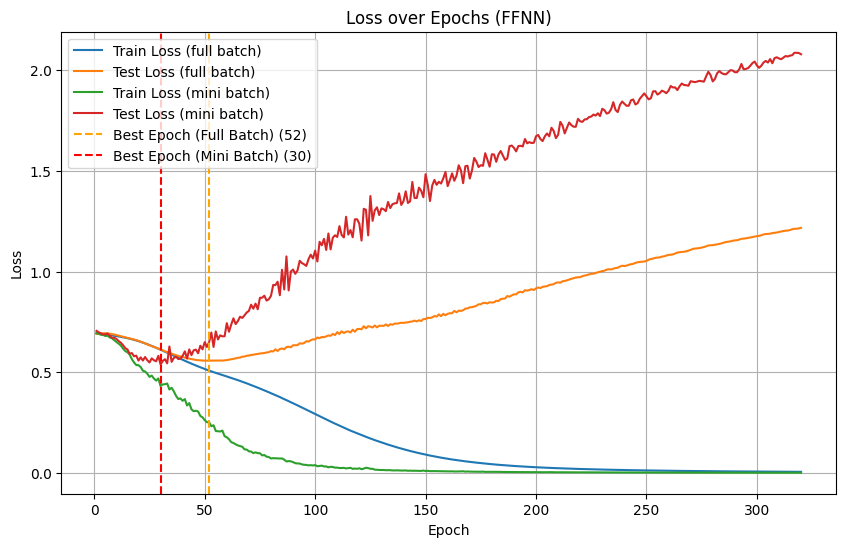

In [ ]:
# === Find the epoch with the lowest test loss ===
best_epoch_full_batch = np.argmin(test_losses)  # index of minimum test loss
best_test_loss = test_losses[best_epoch_full_batch]
best_test_acc = test_accuracies[best_epoch_full_batch]

best_epoch_mini_batch = np.argmin(test_losses_batches)
best_test_loss_batch = test_losses[best_epoch_mini_batch]
best_test_acc_batch = test_accuracies[best_epoch_mini_batch]

plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss (full batch)')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss (full batch)')
plt.plot(range(1, num_epochs+1), train_losses_batches, label='Train Loss (mini batch)')
plt.plot(range(1, num_epochs+1), test_losses_batches, label='Test Loss (mini batch)')

# Mark the best epochs
plt.axvline(x=best_epoch_full_batch+1, color='orange', linestyle='--', label=f'Best Epoch (Full Batch) ({best_epoch_full_batch+1})')
plt.axvline(x=best_epoch_mini_batch+1, color='red', linestyle='--', label=f'Best Epoch (Mini Batch) ({best_epoch_mini_batch+1})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss over Epochs ({ffnn_model_type})')
plt.legend()
plt.grid()
plt.show()

## **Transformer**

In [ ]:
class TinyTransformer(nn.Module):
    def __init__(self, seq_len, feature_dim):
        super().__init__()
        self.input_proj = nn.Linear(feature_dim, 64)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=4, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.classifier = nn.Linear(seq_len * 64, 2)

        # NEW: to save attention maps
        self.attention_maps = []

    def forward(self, x):
        x = self.input_proj(x)

        # Clear previous attention maps
        self.attention_maps = []

        # Instead of self.transformer(x), we loop manually
        for layer in self.transformer.layers:
            x, attn = self.forward_with_attention(layer, x)
            self.attention_maps.append(attn)

        x = x.flatten(start_dim=1)
        return self.classifier(x)

    def forward_with_attention(self, layer, x):
        """
        Forward through a TransformerEncoderLayer and grab the attention map.
        """
        # Accessing the self-attention module inside TransformerEncoderLayer
        src2, attn_weights = layer.self_attn(x, x, x, need_weights=True, average_attn_weights=False)
        x = x + layer.dropout1(src2)
        x = layer.norm1(x)

        src2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(x))))
        x = x + layer.dropout2(src2)
        x = layer.norm2(x)

        return x, attn_weights

In [ ]:
transformer_model = TinyTransformer(seq_len=X_train_t_seq.shape[1], feature_dim=X_train_t_seq.shape[2])
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=1e-3)

epochs = 30

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    transformer_model.train()
    optimizer.zero_grad()
    output = transformer_model(X_train_t_seq)
    loss = loss_fn(output, y_train_t_seq)
    loss.backward()
    optimizer.step()

    # Save train loss and accuracy
    train_losses.append(loss.item())
    train_preds = torch.argmax(output, dim=1)
    train_acc = (train_preds == y_train_t_seq).float().mean().item()
    train_accuracies.append(train_acc)

    # Evaluate on test set
    transformer_model.eval()
    with torch.no_grad():
        test_output = transformer_model(X_test_t_seq)
        test_loss = loss_fn(test_output, y_test_t_seq)
        test_losses.append(test_loss.item())

        test_preds = torch.argmax(test_output, dim=1)
        test_acc = (test_preds == y_test_t_seq).float().mean().item()
        test_accuracies.append(test_acc)

transformer_preds = test_preds.numpy()

Plotting results of Transformer:

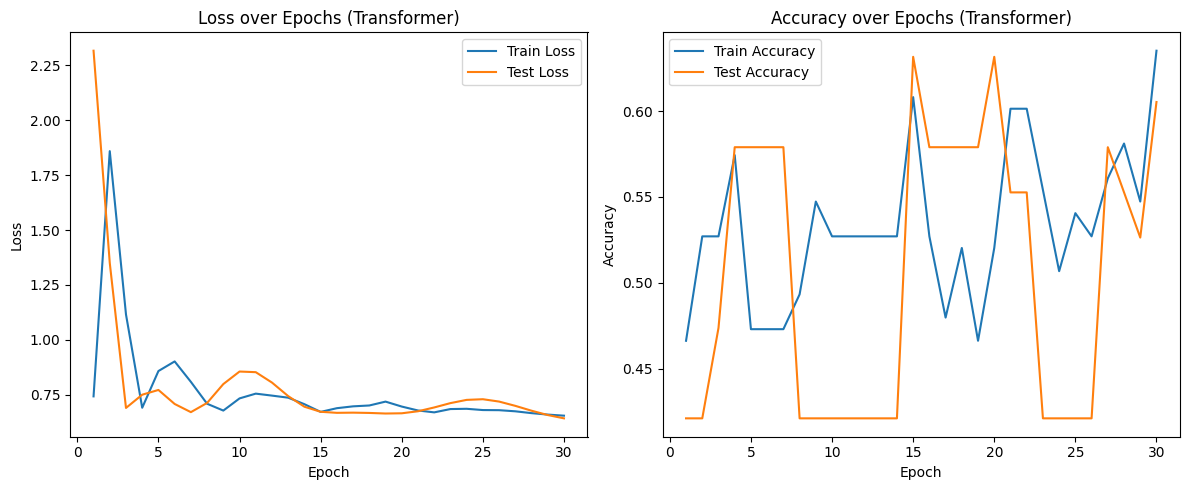

In [ ]:
epochs_range = range(1, epochs + 1)

# Plot losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss over Epochs (Transformer)')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over Epochs (Transformer)')
plt.legend()

plt.tight_layout()
plt.show()

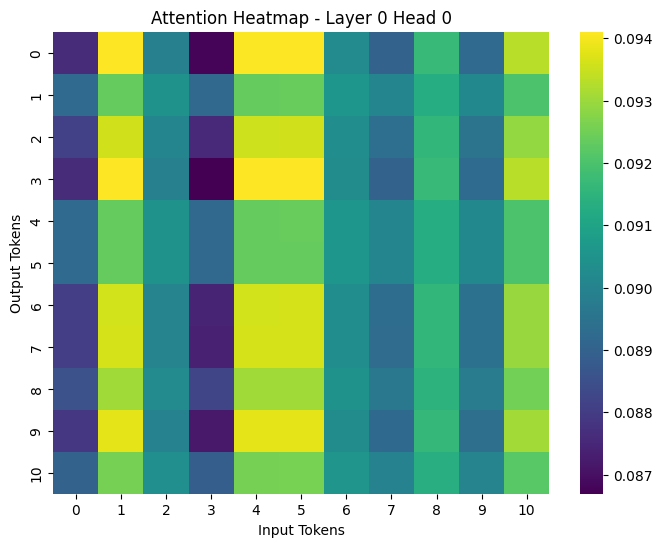

In [ ]:
transformer_model.eval()
with torch.no_grad():
    test_output = transformer_model(X_test_t_seq)
    test_preds = torch.argmax(test_output, dim=1)

# Pick an example (say index 0)
attentions = transformer_model.attention_maps  # List of [batch_size, num_heads, seq_len, seq_len]

# Example: plot first layer, first head, first example
import matplotlib.pyplot as plt
import seaborn as sns

example_idx = 0
layer_idx = 0
head_idx = 0

attn = attentions[layer_idx][example_idx, head_idx]  # [seq_len, seq_len]

plt.figure(figsize=(8,6))
sns.heatmap(attn.cpu().numpy(), cmap="viridis")
plt.title(f"Attention Heatmap - Layer {layer_idx} Head {head_idx}")
plt.xlabel("Input Tokens")
plt.ylabel("Output Tokens")
plt.show()


Transformer Classification Report:

In [ ]:
print(classification_report(y_test_t_seq.numpy(), transformer_preds))

              precision    recall  f1-score   support

           0       0.68      0.59      0.63        22
           1       0.53      0.62      0.57        16

    accuracy                           0.61        38
   macro avg       0.61      0.61      0.60        38
weighted avg       0.62      0.61      0.61        38



## **LSTM**

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2,  # regularization
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        # Take the last hidden state
        return self.fc(hn[-1])

In [ ]:
lstm_model = LSTMClassifier(
    input_dim=X_train_t_seq.shape[2],
    hidden_dim=64,
    num_layers=1,
    output_dim=2
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)

epochs = 55

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    output = lstm_model(X_train_t_seq)
    loss = loss_fn(output, y_train_t_seq)
    loss.backward()
    optimizer.step()

    # Save train loss and accuracy
    train_losses.append(loss.item())
    train_preds = torch.argmax(output, dim=1)
    train_acc = (train_preds == y_train_t_seq).float().mean().item()
    train_accuracies.append(train_acc)

    # Evaluate on test set
    lstm_model.eval()
    with torch.no_grad():
        test_output = lstm_model(X_test_t_seq)
        test_loss = loss_fn(test_output, y_test_t_seq)
        test_losses.append(test_loss.item())

        test_preds = torch.argmax(test_output, dim=1)
        test_acc = (test_preds == y_test_t_seq).float().mean().item()
        test_accuracies.append(test_acc)

lstm_preds = test_preds.numpy()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


LSTM Classification Report:

In [ ]:
print(classification_report(y_test_t_seq.numpy(), lstm_preds))

              precision    recall  f1-score   support

           0       0.90      0.41      0.56        22
           1       0.54      0.94      0.68        16

    accuracy                           0.63        38
   macro avg       0.72      0.67      0.62        38
weighted avg       0.75      0.63      0.61        38



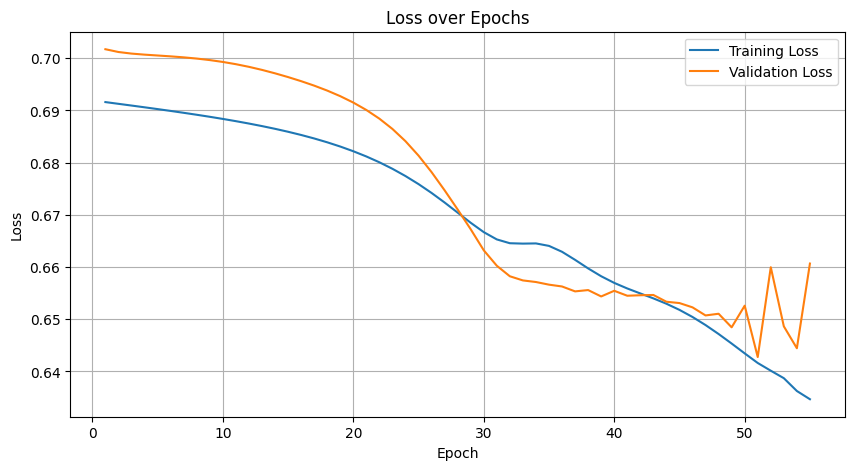

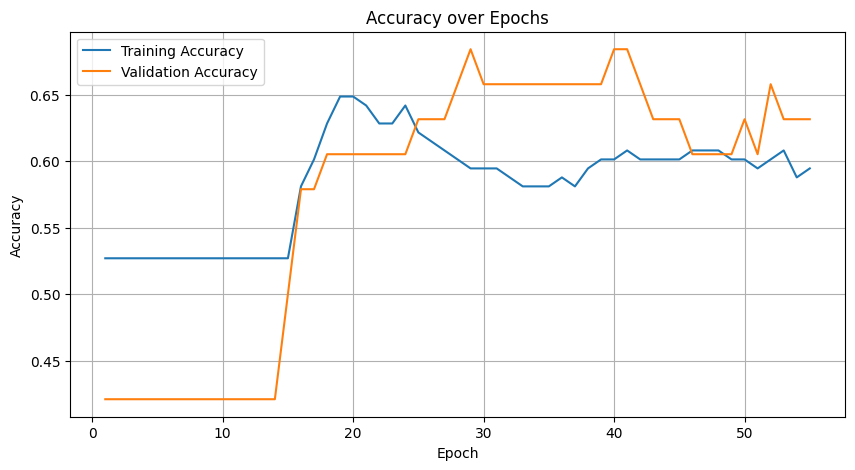

In [ ]:
epochs_range = range(1, epochs + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()



# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, test_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## **RNN**

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2,  # regularization
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, hn = self.rnn(x)
        # Take the last hidden state
        return self.fc(hn[-1])

In [ ]:
rnn_model = RNNClassifier(
    input_dim=X_train_t_seq.shape[2],
    hidden_dim=64,
    num_layers=1,
    output_dim=2
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=1e-3)

epochs = 55

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    rnn_model.train()
    optimizer.zero_grad()
    output = rnn_model(X_train_t_seq)
    loss = loss_fn(output, y_train_t_seq)
    loss.backward()
    optimizer.step()

    # Save train loss and accuracy
    train_losses.append(loss.item())
    train_preds = torch.argmax(output, dim=1)
    train_acc = (train_preds == y_train_t_seq).float().mean().item()
    train_accuracies.append(train_acc)

    # Evaluate on test set
    rnn_model.eval()
    with torch.no_grad():
        test_output = rnn_model(X_test_t_seq)
        test_loss = loss_fn(test_output, y_test_t_seq)
        test_losses.append(test_loss.item())

        test_preds = torch.argmax(test_output, dim=1)
        test_acc = (test_preds == y_test_t_seq).float().mean().item()
        test_accuracies.append(test_acc)

rnn_preds = test_preds.numpy()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


RNN Classification Report:

In [ ]:
print(classification_report(y_test_t_seq.numpy(), rnn_preds))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        22
           1       0.69      0.69      0.69        16

    accuracy                           0.74        38
   macro avg       0.73      0.73      0.73        38
weighted avg       0.74      0.74      0.74        38



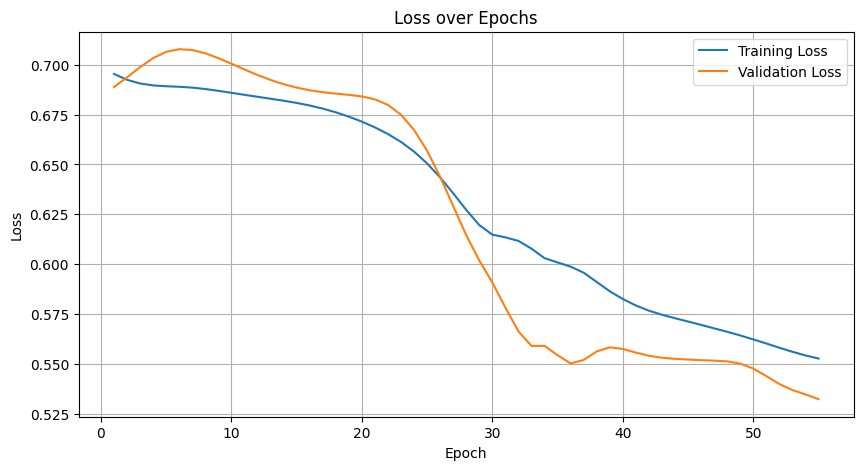

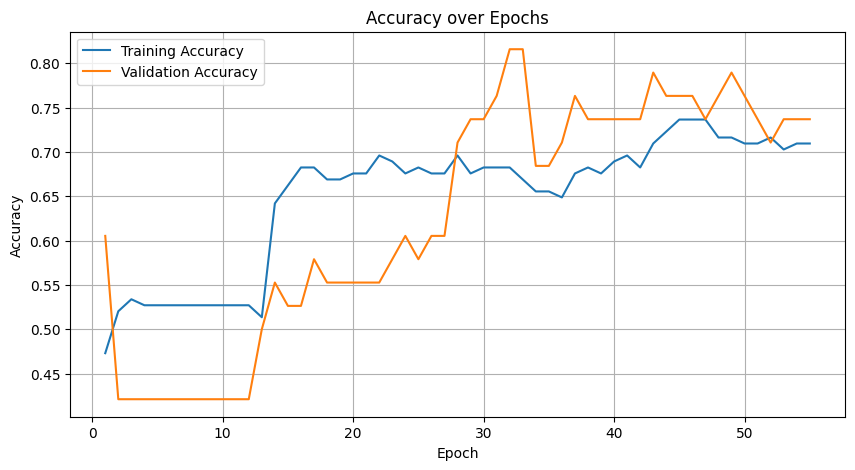

In [ ]:
epochs_range = range(1, epochs + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()



# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, test_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## **CNN**

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, output_dim):
        super(CNNClassifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(16, 5, kernel_size=3, padding=1),
            nn.BatchNorm2d(5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        # Dynamically compute flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 11, 10)
            dummy_output = self.cnn(dummy_input)
            flattened_size = dummy_output.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(flattened_size, output_dim),
        )

    def forward(self, x):
        return self.fc(self.cnn(x))


In [ ]:
print('input size:',X_train_t_seq.shape)
cnn_model = CNNClassifier(
    output_dim=2
)
# Input shape is (148, 11, 10), transform the datatset to 1 in-channel input for the cnn
X_train_t_seq_conv = X_train_t_seq.unsqueeze(1)  # → (148, 1, 11, 10)
X_test_t_seq_conv = X_test_t_seq.unsqueeze(1)  # → (148, 1, 11, 10)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

epochs = 50

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    cnn_model.train()
    optimizer.zero_grad()
    output = cnn_model(X_train_t_seq_conv)
    loss = loss_fn(output, y_train_t_seq)
    loss.backward()
    optimizer.step()

    # Save train loss and accuracy
    train_losses.append(loss.item())
    train_preds = torch.argmax(output, dim=1)
    train_acc = (train_preds == y_train_t_seq).float().mean().item()
    train_accuracies.append(train_acc)

    # Evaluate on test set
    cnn_model.eval()
    with torch.no_grad():
        test_output = cnn_model(X_test_t_seq_conv)
        test_loss = loss_fn(test_output, y_test_t_seq)
        test_losses.append(test_loss.item())

        test_preds = torch.argmax(test_output, dim=1)
        test_acc = (test_preds == y_test_t_seq).float().mean().item()
        test_accuracies.append(test_acc)

cnn_preds = test_preds.numpy()

input size: torch.Size([148, 11, 10])


CNN Classification Report:

In [ ]:
print(classification_report(y_test_t_seq.numpy(), cnn_preds))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76        22
           1       0.67      0.62      0.65        16

    accuracy                           0.71        38
   macro avg       0.70      0.70      0.70        38
weighted avg       0.71      0.71      0.71        38



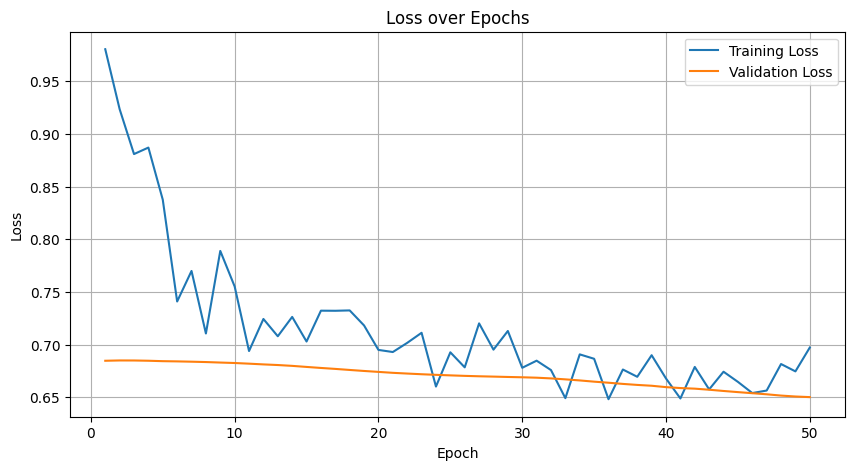

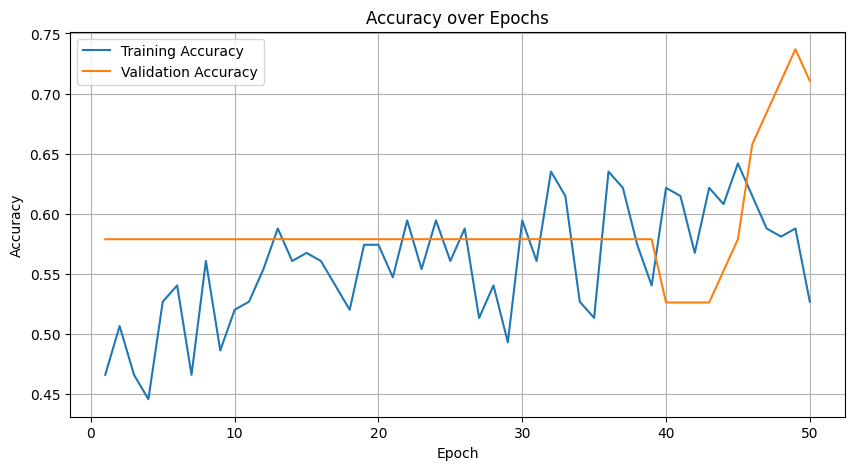

In [ ]:
epochs_range = range(1, epochs + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()



# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, test_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## **Models Accuracies Graph**

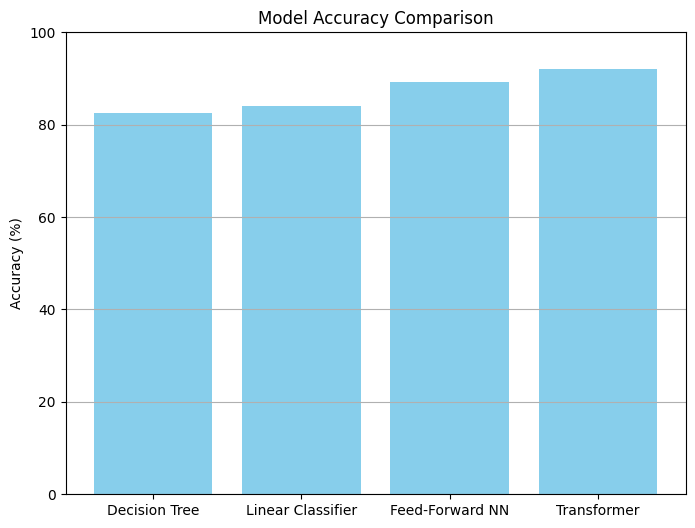

In [ ]:
# Example data - replace with your actual numbers
model_names = ['Decision Tree', 'Linear Classifier', 'Feed-Forward NN', 'Transformer']
accuracies = [82.5, 84.0, 89.3, 92.1]

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.ylim(0, 100)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y')
plt.show()
